<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [26]:
import torch
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from torchviz import make_dot
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.pytorch

## Utils

In [2]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

## Data Transformation

In [3]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [4]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [6]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 4
Imagem 1, Label: 1
Imagem 2, Label: 2
Imagem 3, Label: 0
Imagem 4, Label: 0
Imagem 5, Label: 2
Imagem 6, Label: 0
Imagem 7, Label: 0


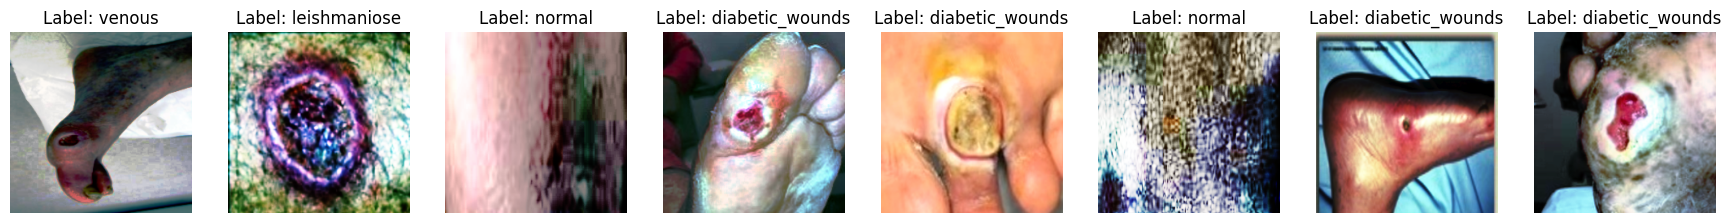

In [7]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo

    # Definir o rótulo baseado no valor
    if label_value == 0:
        label_text = 'diabetic_wounds'
    elif label_value == 1:
        label_text = 'leishmaniose'
    elif label_value == 2:
        label_text = 'normal'
    elif label_value == 3:
        label_text = 'pyoderma'
    elif label_value == 4:
        label_text = 'venous'
    else:
        label_text = 'unknown'

    ax = axes[i]
    ax.set_title(f"Label: {label_text}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [8]:
train_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [9]:
test_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [10]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 1261


In [11]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 40


In [12]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


In [13]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


## Model Train

In [14]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

In [15]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [16]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [17]:
num_classes

5

In [18]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [19]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
device

device(type='cpu')

In [23]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch [1/80], Loss: 0.4471
Epoch [2/80], Loss: 0.3132
Epoch [3/80], Loss: 0.1936
Epoch [4/80], Loss: 0.1821
Epoch [5/80], Loss: 0.1706
Epoch [6/80], Loss: 0.1919
Epoch [7/80], Loss: 0.1494
Epoch [8/80], Loss: 0.1383
Epoch [9/80], Loss: 0.1750
Epoch [10/80], Loss: 0.1479
Epoch [11/80], Loss: 0.1664
Epoch [12/80], Loss: 0.1121
Epoch [13/80], Loss: 0.1294
Epoch [14/80], Loss: 0.1396
Epoch [15/80], Loss: 0.1295
Epoch [16/80], Loss: 0.1180
Epoch [17/80], Loss: 0.1019
Epoch [18/80], Loss: 0.1323
Epoch [19/80], Loss: 0.1503
Epoch [20/80], Loss: 0.1250
Epoch [21/80], Loss: 0.1165
Epoch [22/80], Loss: 0.1135
Epoch [23/80], Loss: 0.1171
Epoch [24/80], Loss: 0.1089
Epoch [25/80], Loss: 0.1157
Epoch [26/80], Loss: 0.0739
Epoch [27/80], Loss: 0.1030
Epoch [28/80], Loss: 0.1008
Epoch [29/80], Loss: 0.1426
Epoch [30/80], Loss: 0.1215
Epoch [31/80], Loss: 0.1229
Epoch [32/80], Loss: 0.0857
Epoch [33/80], Loss: 0.1168
Epoch [34/80], Loss: 0.1136
Epoch [35/80], Loss: 0.1299
Epoch [36/80], Loss: 0.0884
E

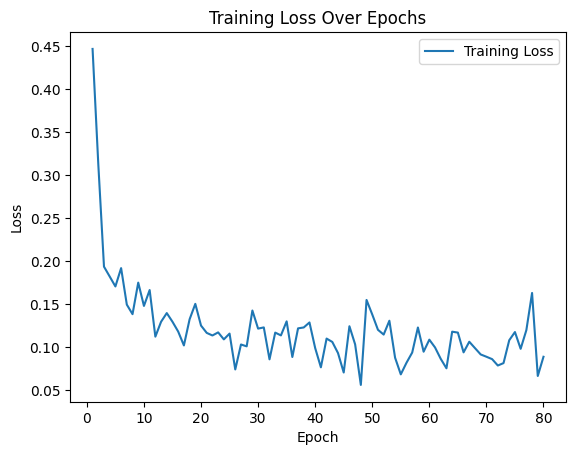

In [24]:
num_epochs = 80
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Model Evatualion + Mlflow Tracking

2024/11/22 20:41:22 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.5.1, but the installed version is 2.5.1+cpu. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.


100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


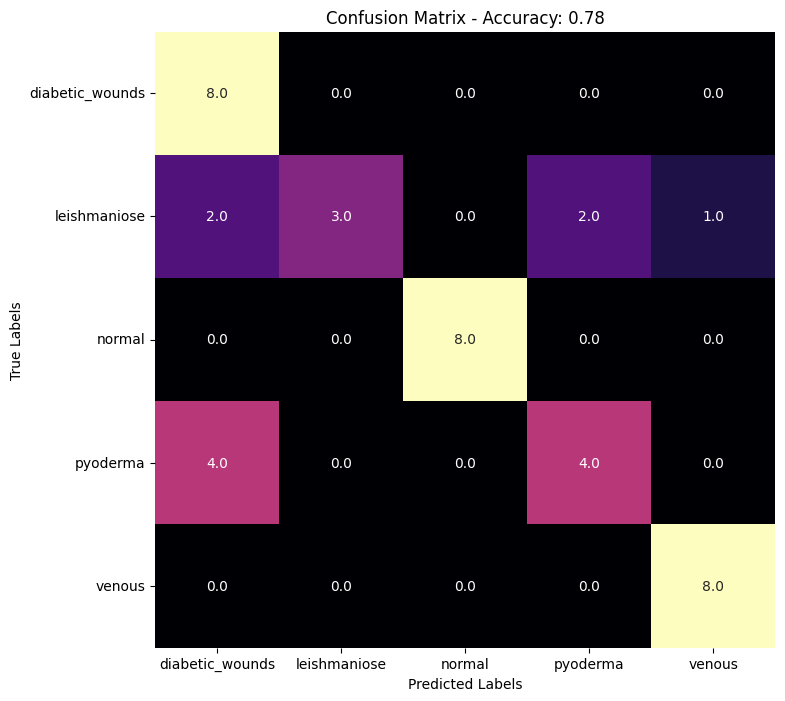

2024/11/22 20:41:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AlexNet-pre-trained at: http://127.0.0.1:5000/#/experiments/298940287065287300/runs/835b0f2a598b4692b40dfc9c2a548c93
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/298940287065287300


In [ ]:
# Avaliação do modelo
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("LeishticIA_test")
# Auto log all MLflow entities
mlflow.pytorch.autolog()

with mlflow.start_run(run_name='AlexNet-pre-trained'):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # Armazene os rótulos e as previsões
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average="macro",)
        recall = recall_score(all_labels, all_predictions, average="macro",)
        roc_auc = roc_auc_score(all_labels, all_predictions)

        # Criar a matriz de confusão
        cm = confusion_matrix(all_labels, all_predictions)

        # Plotar a matriz de confusão com Seaborn
        plt.figure(figsize=(8, 8))
        ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - Accuracy: {acc:.2f}')
        ax.set_xticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'])
        ax.set_yticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'], rotation=0)
        plt.savefig('AlexNet_Confusion_Matrix_Test_Set.png')
        plt.show()

        mlflow.log_metric('accuracy', acc)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('roc_auc_score', roc_auc)
        mlflow.log_param('num_classes', num_classes)
        mlflow.log_artifact("AlexNet_Confusion_Matrix_Test_Set.png")
        mlflow.pytorch.log_model(model, f'alexnet_acc_{acc:.2f}_num_classes{num_classes}')
            

In [36]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.38      0.55         8
           2       1.00      1.00      1.00         8
           3       0.67      0.50      0.57         8
           4       0.89      1.00      0.94         8

    accuracy                           0.78        40
   macro avg       0.83      0.78      0.76        40
weighted avg       0.83      0.78      0.76        40



## Model Deployment

In [38]:
# Salvar o modelo após o treinamento
torch.save(model.state_dict(), f'model/alexnet_acc_{acc:.2f}_weights.pth')

# Explainable AI

## Utils

In [ ]:
class AlexNetGradCAM(nn.Module):
    def __init__(self):
        super(AlexNetGradCAM, self).__init__()

        # Carrega o modelo AlexNet pré-treinado
        self.alexnet = models.alexnet(pretrained=False)
        self.alexnet.classifier[6] = nn.Linear(4096, 5)
        self.alexnet.load_state_dict(torch.load(f'model/alexnet_acc_{acc:.2f}_num_classes{num_classes}_weights.pth'))

        # Extrai as camadas convolucionais até a última camada de ativação desejada
        self.features_conv = self.alexnet.features[:12]

        # Extrai o classificador
        self.classifier = self.alexnet.classifier

        # Placeholder para os gradientes
        self.gradients = None

    # Hook para capturar os gradientes das ativações
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # Registra o hook na última camada convolucional
        h = x.register_hook(self.activations_hook)

        # Flatten e passa pelo classificador
        x = F.adaptive_avg_pool2d(x, (6, 6))  # Ajuste para o classificador da AlexNet
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    # Método para extrair os gradientes
    def get_activations_gradient(self):
        return self.gradients

    # Método para extrair as ativações
    def get_activations(self, x):
        return self.features_conv(x)

# Inicializa o modelo
model = AlexNetGradCAM()
model.eval()

# Função para aplicar o Grad-CAM
def generate_gradcam_heatmap(model, img_tensor, target_class=None):
    # Realiza a predição e captura o índice da classe
    pred = model(img_tensor)
    if target_class is None:
        target_class = pred.argmax(dim=1).item()

    # Calcula o gradiente da classe-alvo em relação à saída
    model.zero_grad()
    pred[:, target_class].backward()

    # Extrai o gradiente médio em cada canal da última camada convolucional
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Extrai as ativações da última camada convolucional
    activations = model.get_activations(img_tensor).detach()

    # Pondera as ativações pelo gradiente médio
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Calcula o heatmap médio nas ativações
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Aplica ReLU e normaliza
    heatmap = F.relu(heatmap)
    heatmap /= heatmap.max()
    return heatmap.numpy()

c:\Users\erico\Documents\leishticIA\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\erico\Documents\leishticIA\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\erico\AppData\Local\Temp\ipykernel_28456\55621716.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `

In [44]:
# model = models.alexnet(pretrained=False)
# model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
# model.load_state_dict(torch.load(f'/content/alexnet_acc_{accuracy:.2f}_weights.pth'))
# model.eval()

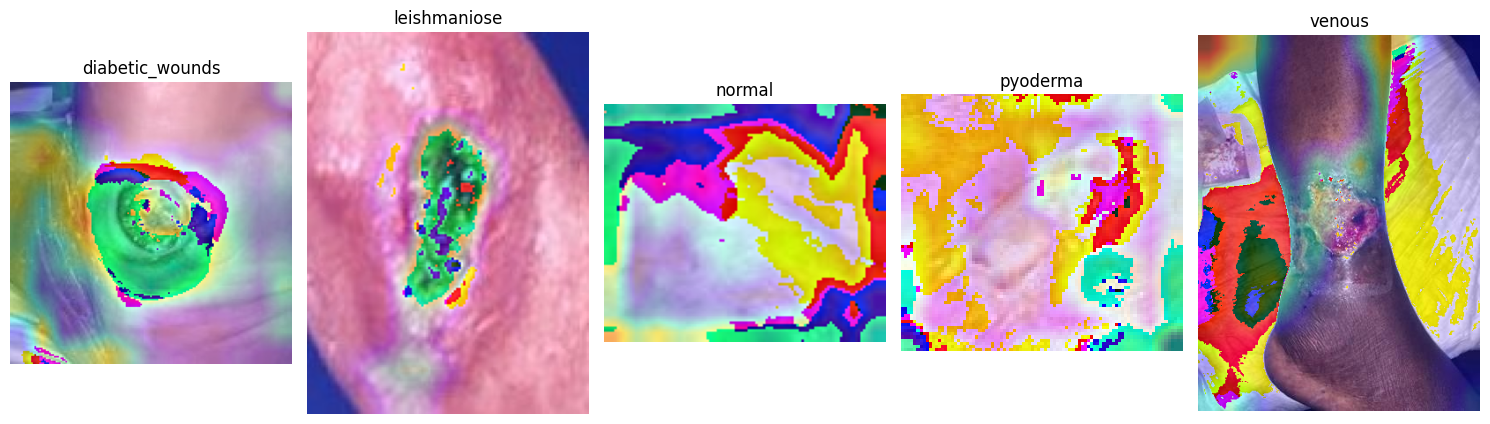

In [45]:
# Carregue uma imagem para teste
image_paths = ['dataset_classifier/test/diabetic_wounds/13_0.jpg',
               'dataset_classifier/test/leishmaniose/01.jpg',
               'dataset_classifier/test/normal/0711.jpg',
               'dataset_classifier/test/pyoderma/01.jpg',
               'dataset_classifier/test/venous/1558.jpg']

labels = ['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

# Pré-processamento das imagens
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Configura o layout dos subplots
n_rows = 1  # número de linhas
n_cols = 5  # número de colunas (ajuste conforme necessário)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Itera sobre as imagens e exibe com Grad-CAM
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    # Carrega e pré-processa a imagem
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)

    # Gera o heatmap Grad-CAM
    heatmap = generate_gradcam_heatmap(model, img_tensor)

    # Carrega a imagem original para sobrepor o heatmap
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = jet_heatmap * 0.4 + img
    # Converte para uint8 antes de aplicar cvtColor
    superimposed_img = np.uint8(superimposed_img)
    # Converte para RGB para exibição com matplotlib
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Exibe a imagem com título da label
    axes[i].imshow(superimposed_img)
    axes[i].set_title(label)
    axes[i].axis('off')

# Ajusta o layout
plt.tight_layout()
plt.show()